# Ep5: Automatic Program Optimization

tvm 的精髓：autotvm & ansor。

1. 使用 `meta_schedule.tune_tir` API，可以自动搜索最优的 schedule。
2. 调用 `tune_tir` 时，可以手动指定 search space，但，如果写的太简单了，效果很可能不如默认版本。
3. 可以把 Model 里的特定算子拿出来，单独调用 `tune_tir` 优化，并把优化后的算子，放回 Model。

备注：

1. 原课程花了大量篇幅讲采样搜索的最优化方法。实际，对应的 TVM API 很简单。熟悉最优化理论的，直接看 API 就够了。
2. 搜索算法，依赖 xgboost。 `pip install xgboost`

In [1]:
import tvm
from tvm.ir.module import IRModule

from tvm.script import tir as T, relax as R
from tvm import te

from tvm import relax
# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations 

import torch

import numpy as np
import pickle

print('tvm versin: %s' % tvm.__version__)

tvm versin: 0.13.dev0


## 1. 高性能算子的最优化搜索

single tensor primitive function 的 loop 优化

- 原始算子: 1.531 ms
- 手动优化: 0.324 ms
- 自动优化 - 指定 search space: 0.105 ms (不稳定)
- 自动优化 - 默认 search space: 0.096 ms (见过 0.03 以下)

### 1.1 原始的算子实现

In [2]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def main(
        A: T.Buffer((128, 128), "float32"),
        B: T.Buffer((128, 128), "float32"),
        C: T.Buffer((128, 128), "float32"),
    ):
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        for i, j, k in T.grid(128, 128, 128):
            with T.block("C"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    C[vi, vj] = 0.0
                C[vi, vj] = C[vi, vj] + A[vi, vk] * B[vk, vj]

First, let us define a set of inputs and outputs for evaluation.

In [3]:
dtype = "float32"
a_np = np.random.rand(128, 128).astype(dtype)
b_np = np.random.rand(128, 128).astype(dtype)
c_mm = a_np @ b_np

a_nd = tvm.nd.array(a_np)
b_nd = tvm.nd.array(b_np)
c_nd = tvm.nd.empty((128, 128), dtype="float32")

We can build and run `MyModule` as follows.





In [4]:
lib = tvm.build(MyModule, target="llvm")
f_timer_before = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule: %.3f ms" % (f_timer_before(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule: 1.433 ms


### 1.2 手动优化

In [5]:
def schedule_mm(sch: tvm.tir.Schedule, jfactor=4):
    block_C = sch.get_block("C", "main")
    i, j, k = sch.get_loops(block=block_C)
    j_0, j_1 = sch.split(loop=j, factors=[None, jfactor])
    sch.reorder(i, j_0, k, j_1)
    sch.decompose_reduction(block_C, k)
    return sch

In [6]:
sch = tvm.tir.Schedule(MyModule)
sch = schedule_mm(sch)
# sch.mod.show()

lib = tvm.build(sch.mod, target="llvm")
f_timer_after = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule=>schedule_mm: %.3f ms" % (f_timer_after(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule=>schedule_mm: 0.326 ms


### 1.3 定义搜索空间，自动搜索

很简单，就 2 步：
1. 基于 `sch.sample_perfect_tile` API 随机采样。trace 时输出的 `decision=[...]`，是最近一次执行的采样结果，即，当前使用的采样结果。
2. 使用 `meta_schedule.tune_tir` API，基于 xgboost，进行最优化搜索

In [7]:
def stochastic_schedule_mm(sch: tvm.tir.Schedule):
    block_C = sch.get_block("C", "main")
    i, j, k = sch.get_loops(block=block_C)

    # sample j_factors so that we can generate a search space and pick the best one
    j_factors = sch.sample_perfect_tile(loop=j, n=2)
    # type(j_factors[0]): tvm.tir.expr.Var

    j_0, j_1 = sch.split(loop=j, factors=j_factors)
    sch.reorder(i, j_0, k, j_1)
    sch.decompose_reduction(block_C, k)
    return sch

In [8]:
# re-run and trace, we can see the decision=[...] is changing
sch = tvm.tir.Schedule(MyModule)
sch = stochastic_schedule_mm(sch)

# sch.mod.show()
print(sch.trace)

# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  l1, l2, l3 = sch.get_loops(block=b0)
  v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[64, 2])
  l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
  sch.reorder(l1, l6, l3, l7)
  b8 = sch.decompose_reduction(block=b0, loop=l3)


使用自定义的 stochastic_schedule_mm 构造搜索空间，使用 `meta_schedule.tune_tir` API，进行最优化搜索。

In [9]:
from tvm import meta_schedule as ms

database = ms.tune_tir(
    mod=MyModule,
    target="llvm --num-cores=1",
    max_trials_global=64,
    num_trials_per_iter=64,
    space=ms.space_generator.ScheduleFn(stochastic_schedule_mm),
    work_dir="./tune_tmp",
    # task_name="main"
)

2023-06-11 08:47:08 [INFO] Logging directory: ./tune_tmp/logs
2023-06-11 08:47:17 [INFO] LocalBuilder: max_workers = 8
2023-06-11 08:47:17 [INFO] LocalRunner: max_workers = 1
2023-06-11 08:47:18 [INFO] [task_scheduler.cc:159] Initializing Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,N/A,N/A,N/A,0,


2023-06-11 08:47:18 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |            N/A |          N/A |                   N/A |      0 |      
------------------------------------------------------------------------------------------------------
Total trials: 0
Total latency (us): 0


Total trials: 0
Total latency (us): 0

2023-06-11 08:47:18 [INFO] [task_scheduler.cc:180] TaskScheduler picks Task #0: "main"
2023-06-11 08:47:19 [INFO] [task_scheduler.cc:193] Sending 62 sample(s) to builder
2023-06-11 08:47:27 [INFO] [task_scheduler.cc:195] Sending 62 sample(s) to runner
2023-06-11 08:48:07 [DEBUG] XGB iter   0: tr-p-rmse: 0.433670	tr-a-peak@32: 0.997361	tr-rmse: 0.268158	tr-rmse: 0.268158
2023-06-11 08:48:07 [DEBUG] XGB iter  25: tr-p-rmse: 0.052074	tr-a-peak@32: 1.00000

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,128.9990,32.5142,32.5142,62,



Total trials: 62
Total latency (us): 32.5142

2023-06-11 08:48:07 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |       128.9990 |      32.5142 |               32.5142 |     62 |      
------------------------------------------------------------------------------------------------------
Total trials: 62
Total latency (us): 32.5142

2023-06-11 08:48:07 [INFO] [task_scheduler.cc:180] TaskScheduler picks Task #0: "main"
2023-06-11 08:48:08 [INFO] [task_scheduler.cc:193] Sending 2 sample(s) to builder
2023-06-11 08:48:10 [INFO] [task_scheduler.cc:195] Sending 2 sample(s) to runner
2023-06-11 08:48:11 [DEBUG] XGB validation: p-rmse: 0.410776	a-peak@32: 1.000000
2023-06-11 08:48:11 [INFO] [task_scheduler.cc:237] [Updated] Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,128.9990,32.5142,32.5142,64,


2023-06-11 08:48:11 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |       128.9990 |      32.5142 |               32.5142 |     64 |      
------------------------------------------------------------------------------------------------------
Total trials: 64
Total latency (us): 32.5142


Total trials: 64
Total latency (us): 32.5142

2023-06-11 08:48:11 [INFO] [task_scheduler.cc:260] Task #0 has finished. Remaining task(s): 0


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,128.9990,32.5142,32.5142,64,Y


2023-06-11 08:48:11 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |       128.9990 |      32.5142 |               32.5142 |     64 |    Y 
------------------------------------------------------------------------------------------------------
Total trials: 64
Total latency (us): 32.5142


Total trials: 64
Total latency (us): 32.5142



`tune_tir` functions return an optimized schedule found during the tuning process.

通过 trace 从 d·ecision 里找搜索结果

In [10]:
sch_tuned = ms.tir_integration.compile_tir(database, MyModule, target="llvm --num-cores=1")
# print(sch_tuned.trace)
# sch_tuned.mod.show()

lib = tvm.build(sch_tuned.mod, target="llvm")
f_timer_after = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule after tuning: %.3f ms" % (f_timer_after(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule after tuning: 0.105 ms


### 1.4 使用 TVM 的默认搜索空间

效果可能更好

In [11]:
database = ms.tune_tir(
    mod=MyModule,
    target="llvm --num-cores=1",
    max_trials_global=64,
    num_trials_per_iter=64,
    work_dir="./tune_tmp",
    # task_name="main",
)

2023-06-11 08:48:16 [INFO] Logging directory: ./tune_tmp/logs
2023-06-11 08:48:16 [INFO] LocalBuilder: max_workers = 8
2023-06-11 08:48:17 [INFO] LocalRunner: max_workers = 1
2023-06-11 08:48:17 [INFO] [task_scheduler.cc:159] Initializing Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,N/A,N/A,N/A,0,


2023-06-11 08:48:17 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |            N/A |          N/A |                   N/A |      0 |      
------------------------------------------------------------------------------------------------------
Total trials: 0
Total latency (us): 0


Total trials: 0
Total latency (us): 0

2023-06-11 08:48:17 [INFO] [task_scheduler.cc:180] TaskScheduler picks Task #0: "main"
2023-06-11 08:48:20 [INFO] [task_scheduler.cc:193] Sending 64 sample(s) to builder
2023-06-11 08:48:30 [INFO] [task_scheduler.cc:195] Sending 64 sample(s) to runner
2023-06-11 08:49:16 [DEBUG] XGB iter   0: tr-p-rmse: 0.373865	tr-a-peak@32: 1.000000	tr-rmse: 0.259371	tr-rmse: 0.259371
2023-06-11 08:49:16 [DEBUG] XGB iter  25: tr-p-rmse: 0.040294	tr-a-peak@32: 1.00000

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,124.6979,33.6357,33.6357,64,



Total trials: 64
Total latency (us): 33.6357

2023-06-11 08:49:16 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |       124.6979 |      33.6357 |               33.6357 |     64 |      
------------------------------------------------------------------------------------------------------
Total trials: 64
Total latency (us): 33.6357

2023-06-11 08:49:16 [INFO] [task_scheduler.cc:260] Task #0 has finished. Remaining task(s): 0


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,124.6979,33.6357,33.6357,64,Y


2023-06-11 08:49:16 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |       124.6979 |      33.6357 |               33.6357 |     64 |    Y 
------------------------------------------------------------------------------------------------------
Total trials: 64
Total latency (us): 33.6357


Total trials: 64
Total latency (us): 33.6357



In [12]:
sch_tuned = ms.tir_integration.compile_tir(database, MyModule, target="llvm --num-cores=1")
# sch_tuned.mod.show()
# print(sch.trace)

lib = tvm.build(sch_tuned.mod, target="llvm")
f_timer_after = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule after tuning: %.3f ms" % (f_timer_after(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule after tuning: 0.096 ms


The result gets much faster than our original code. We can take a glimpse at the trace and the final code. For the purpose of this chapter, you do not need to understand all the transformations. At a high level, the trace involves:

- More levels of loop tiling transformations.
- Vectorization of intermediate computations.
- Parallelization and unrolling of loops. 


In [13]:
sch_tuned.trace

# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  b1 = sch.get_block(name="root", func_name="main")
  sch.annotate(block_or_loop=b0, ann_key="meta_schedule.tiling_structure", ann_val="SSRSRS")
  l2, l3, l4 = sch.get_loops(block=b0)
  v5, v6, v7, v8 = sch.sample_perfect_tile(loop=l2, n=4, max_innermost_factor=64, decision=[32, 4, 1, 1])
  l9, l10, l11, l12 = sch.split(loop=l2, factors=[v5, v6, v7, v8], preserve_unit_iters=True)
  v13, v14, v15, v16 = sch.sample_perfect_tile(loop=l3, n=4, max_innermost_factor=64, decision=[1, 4, 4, 8])
  l17, l18, l19, l20 = sch.split(loop=l3, factors=[v13, v14, v15, v16], preserve_unit_iters=True)
  v21, v22 = sch.sample_perfect_tile(loop=l4, n=2, max_innermost_factor=64, decision=[128, 1])
  l23, l24 = sch.split(loop=l4, factors=[v21, v22], preserve_unit_iters=True)
  sch.reorder(l9, l17, l10, l18, l23, l11, l19, l24, l12, l20)
  b25 = sch.cache_write(block=b0, write_buffer_index=0, sto

## 2. 优化 2-layer MLP 模型

- 优化前: 0.187212 ms
- 优化后: 0.148056 ms

### 2.1 原始的模型实现

使用与 chap 04 课相同的 MLP 模型。

In [14]:
param_file = 'fasionmnist_mlp_params.pkl'
mlp_params = pickle.load(open(param_file, "rb"))

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

image_filename = 'fasionmnist_image_Trouser.pkl'
label = 1

with open(image_filename, 'rb') as f:
    img = pickle.load(f)

data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

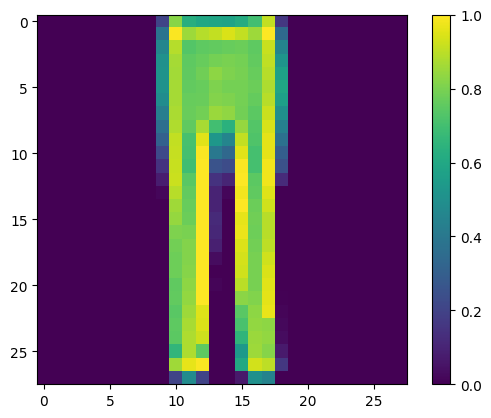

Class: Trouser


In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img)
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label])

Let us use a mixture module where most of the components call into environment function and also come with one TensorIR function `linear0`.

In [16]:
@tvm.script.ir_module
class MyModuleMixture: 
    @T.prim_func
    def linear0(X: T.Buffer((1, 784), "float32"), 
                W: T.Buffer((128, 784), "float32"), 
                B: T.Buffer((128,), "float32"), 
                Z: T.Buffer((1, 128), "float32")):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
    
        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @R.function
    def main(x: R.Tensor((1, 784), "float32"), 
             w0: R.Tensor((128, 784), "float32"), 
             b0: R.Tensor((128,), "float32"), 
             w1: R.Tensor((10, 128), "float32"), 
             b1: R.Tensor((10,), "float32")):
        with R.dataflow():
            cls = MyModuleMixture
            lv0 = R.call_tir(cls.linear0, (x, w0, b0), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_dps_packed("env.relu", (lv0,), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            out = R.call_dps_packed("env.linear", (lv1, w1, b1), out_sinfo=R.Tensor((1, 10), dtype="float32"))
            R.output(out)
        return out

MyModuleWithParams = relax.transform.BindParams("main", nd_params)(MyModuleMixture)

In [17]:
@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray, 
                 w: tvm.nd.NDArray, 
                 b: tvm.nd.NDArray, 
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)

@tvm.register_func("env.relu", override=True)
def lnumpy_relu(x: tvm.nd.NDArray, 
                out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    torch.maximum(x_torch, torch.Tensor([0.0]), out=out_torch)

In [18]:
ex = relax.build(MyModuleWithParams, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams Prediction:", class_names[pred_kind[0]])

MyModuleWithParams Prediction: Trouser


In [19]:
ftimer = vm.module.time_evaluator("main", tvm.cpu(), number=100)

print("MyModuleWithParams time-cost: %g ms" % (ftimer(data_nd).mean * 1000))

MyModuleWithParams time-cost: 0.187212 ms


### 2.2 优化模型的 linear0 算子

优化的流程如下图:

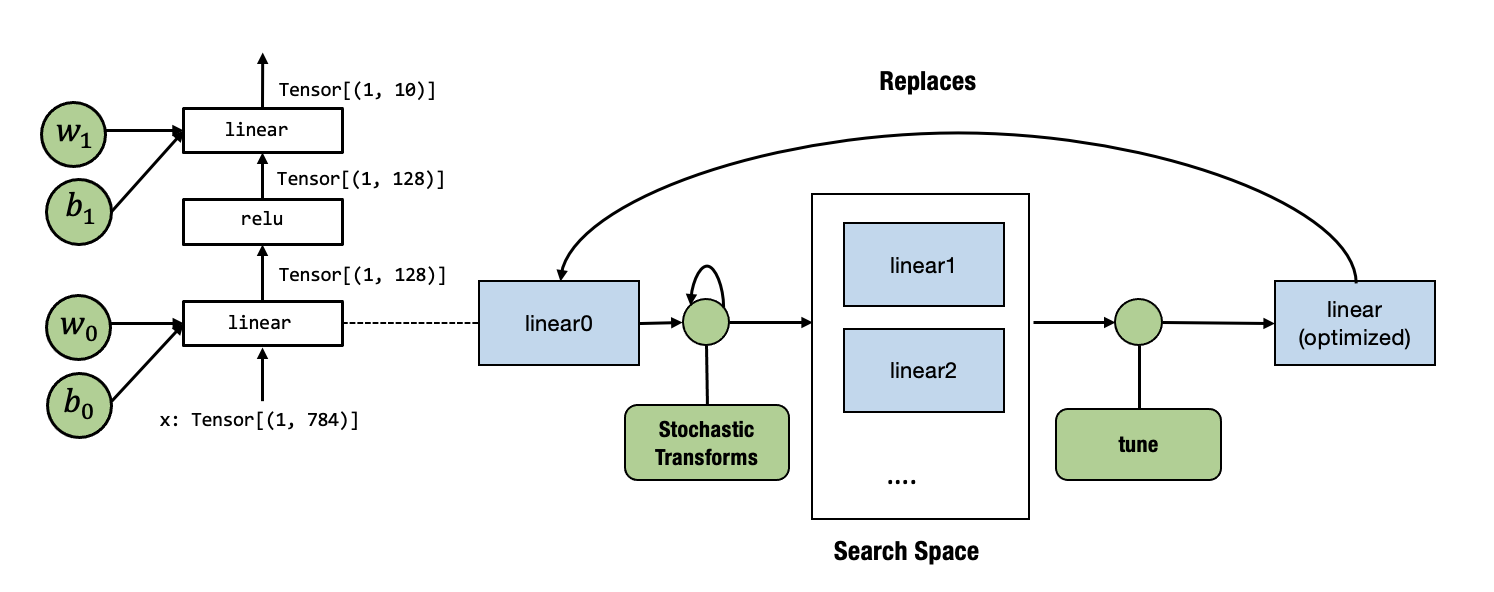

Currently, tune API only takes an IRModule with one `main` function, so we first get the `linear0` out into another module's main function and pass it to tune

In [20]:
mod_linear = tvm.IRModule.from_expr(MyModuleMixture["linear0"].with_attr("global_symbol", "main"))
# mod_linear = tvm.IRModule.from_expr(MyModuleMixture["linear0"])
# mod_linear.show()

In [21]:
database = ms.tune_tir(
    mod=mod_linear,
    target="llvm --num-cores=1",
    max_trials_global=64,
    num_trials_per_iter=64,
    work_dir="./tune_tmp",
    # task_name="main",
)

2023-06-11 08:49:23 [INFO] Logging directory: ./tune_tmp/logs
2023-06-11 08:49:23 [INFO] LocalBuilder: max_workers = 8
2023-06-11 08:49:24 [INFO] LocalRunner: max_workers = 1
2023-06-11 08:49:24 [INFO] [task_scheduler.cc:159] Initializing Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,200832,1,N/A,N/A,N/A,0,



Total trials: 0
Total latency (us): 0

2023-06-11 08:49:24 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |   FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
-----------------------------------------------------------------------------------------------------
  0 | main | 200832 |      1 |            N/A |          N/A |                   N/A |      0 |      
-----------------------------------------------------------------------------------------------------
Total trials: 0
Total latency (us): 0

2023-06-11 08:49:24 [INFO] [task_scheduler.cc:180] TaskScheduler picks Task #0: "main"
2023-06-11 08:49:27 [INFO] [task_scheduler.cc:193] Sending 64 sample(s) to builder
2023-06-11 08:49:33 [INFO] [task_scheduler.cc:195] Sending 64 sample(s) to runner
2023-06-11 08:50:16 [DEBUG] XGB iter   0: tr-p-rmse: 0.434883	tr-a-peak@32: 1.000000	tr-rmse: 0.229909	tr-rmse: 0.229909
2023-06-11 08:50:16 [DEBUG] XGB iter  25: tr-p-rmse: 0.043988	tr-a-peak@32: 1.000000	tr

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,200832,1,29.1729,6.8842,6.8842,64,



Total trials: 64
Total latency (us): 6.88419

2023-06-11 08:50:16 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |   FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
-----------------------------------------------------------------------------------------------------
  0 | main | 200832 |      1 |        29.1729 |       6.8842 |                6.8842 |     64 |      
-----------------------------------------------------------------------------------------------------
Total trials: 64
Total latency (us): 6.88419

2023-06-11 08:50:16 [INFO] [task_scheduler.cc:260] Task #0 has finished. Remaining task(s): 0


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,200832,1,29.1729,6.8842,6.8842,64,Y



Total trials: 64
Total latency (us): 6.88419

2023-06-11 08:50:16 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |   FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
-----------------------------------------------------------------------------------------------------
  0 | main | 200832 |      1 |        29.1729 |       6.8842 |                6.8842 |     64 |    Y 
-----------------------------------------------------------------------------------------------------
Total trials: 64
Total latency (us): 6.88419



使用新的 `linear0` 函数，替换掉原来的 `linear0` 函数:

1. getting a `global_var`, a `pointer` reference to the functions inside the IRModule,
2. calling `update_func` to replace the function with the new one.

In [22]:
MyModuleWithParams2 = relax.transform.BindParams("main", nd_params)(MyModuleMixture)

sch_tuned_linear = ms.tir_integration.compile_tir(database, mod_linear, target="llvm --num-cores=1")
new_func = sch_tuned_linear.mod["main"].with_attr("global_symbol", "linear0")
gv = MyModuleWithParams2.get_global_var("linear0")
MyModuleWithParams2.update_func(gv, new_func)

MyModuleWithParams2.show()

In [23]:
ex = relax.build(MyModuleWithParams2, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

# vm["main"].mod.show()
nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams2 Prediction:", class_names[pred_kind[0]])

MyModuleWithParams2 Prediction: Trouser


In [24]:
ftimer = vm.module.time_evaluator("main", tvm.cpu(), number=50)

print("MyModuleWithParams2 time-cost: %g ms" % (ftimer(data_nd).mean * 1000))

MyModuleWithParams2 time-cost: 0.148056 ms
